# QA/QC for CMIP6 CIHP data

In [1]:
import xarray as xr
import geopandas as gp
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numpy as np
import os
import json
#import sys
from collections import defaultdict
#import nc_time_axis
import matplotlib.dates as mdates
import cftime
from dask.diagnostics import ProgressBar

In [2]:
from compliance_checker.runner import ComplianceChecker, CheckSuite
## this is taken from code by Paola Petrelli
def report_test(data, test, files, levels, scores):
    """Report resuls for one kind of test
       
       Input:
           data - json data from checker report as read from file
           test - kind of test to write a report for
           files - a json data reporting scores and warnings for each file
           levels - list of priority levels
           scores - a dictionary to collect each file scores
       Return:
           scores - same as input after updating with the test scores 
           warnings - a dictionary collecting all the warnings by priority level
    """
    #For each file collect scores in scores dictionary
    # and group warnings by priority levels in another dictionary

    print(f"Results for {test} checks")
    print(f"{len(files)} files were checked\n")
    warnings = {l: {} for l in levels}
    for fpath in files:
        fname = fpath.split("/")[-1]
        header = data[fpath][test]['scoreheader']
        header['scored_points'] = data[fpath][test]['scored_points']
        header['possible_points'] = data[fpath][test]['possible_points']
        scores[fpath][test] = header
        for level in levels:
            for w in data[fpath][test][level + "_priorities"]:
                name = w['name'] + ": "
                for m in w['msgs']:
                    try:
                        warnings[level][name+m].append(fname)
                    except:
                        warnings[level][name+m] = [fname]
    for level in levels:
        print(f'{level.capitalize()} priority results\n')
        for m in warnings[level].keys():
            nfiles = len(warnings[level][m])
            print(f'{nfiles} files failed:\n{m}')
            if nfiles < len(files):
                print(f'{[w for w in warnings[level][m]]}\n')
            else:
                print()
    return scores

## below is a rewrite to just output a text string for insertion into a document (including the test step!)
def metadata_test(data_filepath,json_filename,standard='cf'):
    levels = ['high', 'medium', 'low']
    check_suite = CheckSuite()
    check_suite.load_all_available_checkers()
    output_filename=f'{json_filename}_{standard}.json'
    ComplianceChecker.run_checker([data_filepath],[standard],2,'normal',output_filename=output_filename,output_format='json_new')
    with open(output_filename, 'r') as f:
        reportdata = json.loads(f.read())
    warnings = {l: [] for l in levels}
    for level in levels:
        for w in reportdata[data_filepath][standard][level + "_priorities"]:
            name = w['name'] + ": "
            for m in w['msgs']:
                warnings[level].append(name+m)
    
    output_string=f"{standard.upper()}-standard metadata check results\n------------------------------------------\n"
                    
    for level in levels:
        output_string=output_string+(f'=={level.capitalize()} priority results==\n')
        if len(warnings[level])>0:
            for m in warnings[level]:
                output_string=output_string+(m+'\n')
        else:
            output_string=output_string+('No issues\n')
        output_string=output_string+('\n')
    return output_string

## check file name matches contents

In [3]:
def ts_filename_checks(filepath):
    file_name=filepath.split('/')[-1]
    fn_var=file_name.split('_')[0]
    fn_tempres=file_name.split('_')[1]
    fn_model=file_name.split('_')[2]
    fn_ssp=file_name.split('_')[3]
    fn_ripf=file_name.split('_')[4]
    fn_domain=file_name.split('_')[5]
    if file_name.split('_')[6][0:3]=='gwl':
        fn_syear=file_name.split('_')[6].split('-')[1]
        fn_eyear=file_name.split('_')[6].split('-')[-1]
        fn_basedata=file_name.split('_')[8]
    else:
        fn_syear=file_name.split('_')[6].split('-')[0]
        fn_eyear=file_name.split('_')[6].split('-')[-1]
        fn_basedata=file_name.split('_')[8]

    test_file=xr.open_dataset(filepath)
    variable_test=np.isin(fn_var,test_file.data_vars)
    if fn_tempres=='day':
        temporal_res_test=((np.unique(np.diff(test_file.time).astype('timedelta64[D]'))==np.array(np.timedelta64(1,"D")))[0])
    else:
        temporal_res_test="Not coded for this temporal resolution."
    model_test=(fn_model==test_file.cmip6_source_id)
    experiment_test=(fn_ssp==test_file.cmip6_experiment_id)
    varient_test=(fn_ripf==test_file.cmip6_variant_label)

    if fn_syear==fn_eyear:
        if int(fn_syear)%4!=0:
            len_check=(len(test_file['time'])==365)
        elif int(fn_syear)%100==0 and int(fn_syear)%400!=0:
            len_check=(len(test_file['time'])==365)
        else:
            len_check=(len(test_file['time'])==366)
        timerange_test=(np.isin(int(fn_syear),np.unique(test_file['time.year'])) and len_check)
    else:
        year_array=np.arange(int(fn_syear),int(fn_eyear)+1,1)
        no_leap_count=np.sum(year_array%4!=0)+np.sum(np.logical_and(year_array%100==0,year_array%400==0))
        total_days=365*no_leap_count+366*(len(year_array)-no_leap_count)
        len_check=(len(test_file['time'])==total_days)
        timerange_test=(np.isin(int(fn_syear),np.unique(test_file['time.year'])) and np.isin(int(fn_eyear),np.unique(test_file['time.year'])) and len_check)

    output_text=f"""==========================================
{'/'.join(filepath.split('/')[:-1])+'/'}
{filepath.split('/')[-1]}
==========================================
Filename/content match check:
------------------------------------------  
Data variable matches filename: {variable_test}
Data temporal frequency matches filename: {temporal_res_test}
Source model matches filename: {model_test}
Source experiment matches filename: {experiment_test}
Source varient matches filename: {varient_test}
Data timerange matches filename: {timerange_test}"""
    ## --NEED TO CODE-- check observation_id in file matches filename
    ## --NEED TO CODE-- check domain in file matches filename
    ## --NEED TO CODE-- temporal checks for GWL files
    return output_text

## grid check

In [4]:
def grid_checks(filepath):
    output_text="Grid check:\n------------------------------------------\n"
    file_name=filepath.split('/')[-1]
    fn_basedata=file_name.split('_')[5]
    test_file=xr.open_dataset(filepath)
    
    if fn_basedata=='AUS-05' or fn_basedata=='AUS-05i':
        output_text=output_text+("Lat-lon grid matches AGCD: "+str((np.abs(np.diff(test_file.lat)-0.05)<5e-5).all() and (np.abs(np.diff(test_file.lon)-0.05)<5e-5).all()))
    else:
        output_text=output_text+("Lat-lon grid matches BARRA-R2: "+str((np.abs(np.diff(test_file.lat)-0.11)<5e-5).all() and (np.abs(np.diff(test_file.lon)-0.11)<5e-5).all()))
    return output_text

## missing data checks

In [5]:
def missing_data_checks(filepath):
    output_text="Missing data check:\n------------------------------------------\n"
    file_name=filepath.split('/')[-1]
    fn_var=file_name.split('_')[0]
    test_file=xr.open_dataset(filepath)

    spatial_missing=(test_file[fn_var]).isnull().mean(dim='time')
    temporal_missing=(test_file[fn_var]).isnull().mean(dim=('lat','lon'))
    if (spatial_missing>0).any():
        output_text=output_text+("No missing data: "+str(False)+'\nSee additional plots.')

        data=spatial_missing
        fig1= plt.figure(figsize=(11.7,8.3))
        ax=fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
        cd=ax.contourf(data.lon, data.lat, data,transform=ccrs.PlateCarree(),cmap='plasma')
        
        ax.set_xticks(np.arange(np.ceil(test_file.lon.min().data/5)*5,.01+np.floor(test_file.lon.max().data/5)*5,5), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(np.ceil(test_file.lat.min().data/5)*5,.01+np.floor(test_file.lat.max().data/5)*5,5), crs=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        plt.colorbar(cd)
        plt.close()
        
        fig2= plt.figure(figsize=(12, 6))
        data=temporal_missing
        data.plot()
        plt.close()
        figs=[fig1,fig2]
    else:
        output_text=output_text+("No missing data: "+str(True))
        figs=None
    return output_text, figs

## data range checks

In [6]:
from matplotlib import colors as c

def data_range_checks(filepath):
    output_text="Data range check:\n------------------------------------------\n"
    file_name=filepath.split('/')[-1]
    fn_var=file_name.split('_')[0]
    test_file=xr.open_dataset(filepath)

    data_max=test_file[fn_var].max(dim='time',keep_attrs=True)
    data_min=test_file[fn_var].min(dim='time',keep_attrs=True)
    if fn_var=='pr':
        ex_max=1.25*1825 #sensible limit: 1.25 times highest ever recorded daily max pr (Foc-Foc, 7th Jan 1966)
        ex_min=0 #physical limit: can't have negative rainfall
    if fn_var=='tasmax' or fn_var=='tasmin':
        ex_max=50.7+10 #sensible limit: 10 Kelvin above highest ever recorded daily max temp in SW Pacific (Oodnadatta, 2 Jan 1960)
        ex_min=-40 #observed limit: .5 degrees below lowest temp in BARRA-R2 baseline
    if fn_var=='hurs' or fn_var=='hursmax' or fn_var=='hursmin':
        ex_max=100 #physical limit: full saturation (ignoring supersaturation)
        ex_min=0 #physical limit: can't have negative moisture in air
    if fn_var=='rsds':
        ex_max=1412 #physical limit: maximum of TOA solar radiation over course of the year
        ex_min=0 #physical limit: downwelling field, not net field, so no negative values allowed
    if fn_var=='sfcWind' or fn_var=='sfcWindmax':
        ex_max=1.25*113 #sensible limit: 25% above highest recorded wind gust (Barrow Island, 10 April 1996)
        ex_min=0 #physical limit: magnitude field, can't have negative magnitude

    if (data_max>ex_max).any() or (data_min<ex_min).any():
        output_text=output_text+"Data in range: "+str(False)+'\nSee additional plot.'
        fig = plt.figure(figsize=(11.7,8.3))
        ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
        cd=ax.pcolormesh(data_max.lon, data_max.lat, (data_max>ex_max).where(data_max>ex_max),transform=ccrs.PlateCarree(),cmap=c.ListedColormap(['r','b']))
        ax.set_xticks(np.arange(np.ceil(test_file.lon.min().data/10)*10,.01+np.floor(test_file.lon.max().data/10)*10,10), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(np.ceil(test_file.lat.min().data/5)*5,.01+np.floor(test_file.lat.max().data/5)*5,5), crs=ccrs.PlateCarree())
        #ax.set_extent([112,155,-42.5,-10.3])
        ax.coastlines()
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        
        
        ax = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree(central_longitude=180))
        data=test_file[fn_var].min(dim='time',keep_attrs=True)
        cd=ax.contourf(data_min.lon, data_min.lat, (data_min<ex_min).where(data_min<ex_min),transform=ccrs.PlateCarree(),cmap=c.ListedColormap(['r','b']))
        ax.set_xticks(np.arange(np.ceil(test_file.lon.min().data/10)*10,.01+np.floor(test_file.lon.max().data/10)*10,10), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(np.ceil(test_file.lat.min().data/5)*5,.01+np.floor(test_file.lat.max().data/5)*5,5), crs=ccrs.PlateCarree())
        #ax.set_extent([112,155,-42.5,-10.3])
        ax.coastlines()
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
    
        plt.close()
        figs=[fig]
    else:
        output_text=output_text+"Data in range: "+str(True)
        figs=None

    if fn_var=='tasmax':
        test_file2=xr.open_dataset(filepath.replace("tasmax","tasmin"))
        tasmax_test=(test_file[fn_var]>=test_file2['tasmin']).all()
        if tasmax_test==True:
            output_text=output_text+"\ntasmax above or equal to tasmin: "+str(True)
        else:
            output_text=output_text+"\ntasmax above or equal to tasmin: "+str(False)
            pd=(test_file[fn_var]<test_file2['tasmin']).mean(dim='time')
            fig2 = plt.figure(figsize=(11.7,8.3))
            ax = fig2.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
            cd=ax.contourf(pd.lon, pd.lat, pd.where(pd>0),transform=ccrs.PlateCarree())
            ax.set_xticks(np.arange(np.ceil(test_file.lon.min().data/10)*10,.01+np.floor(test_file.lon.max().data/10)*10,10), crs=ccrs.PlateCarree())
            ax.set_yticks(np.arange(np.ceil(test_file.lat.min().data/5)*5,.01+np.floor(test_file.lat.max().data/5)*5,5), crs=ccrs.PlateCarree())
            #ax.set_extent([112,155,-42.5,-10.3])
            ax.coastlines()
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            plt.colorbar(cd,label='proportion where tasmin above tasmax')
            plt.close()
            if figs:
                figs.add(fig2)
            else:
                figs=[fig2]

    return output_text, figs

## Cycle and Latitudinal Band check

In [7]:
def band_plot(filepath):
    file_name=filepath.split('/')[-1]
    fn_var=file_name.split('_')[0]
    test_file=xr.open_dataset(filepath)
    aus_subset=test_file[fn_var].loc[:,-44:-9,112:154]
    
    fig = plt.figure(figsize=(11.7,8.3))
    ax = fig.add_subplot(1, 1, 1)
    if fn_var!='pr':
        aus_subset.max(dim=('lat','lon'),keep_attrs=True).plot(label='AUS max',ax=ax)
    aus_subset.loc[:,-17.5:-12.5].mean(dim=('lat','lon'),keep_attrs=True).plot(label='15 S 5-degree band mean',ax=ax)
    aus_subset.loc[:,-27.5:-22.5].mean(dim=('lat','lon'),keep_attrs=True).plot(label='25 S 5-degree band mean',ax=ax)
    aus_subset.loc[:,-37.5:-32.5].mean(dim=('lat','lon'),keep_attrs=True).plot(label='35 S 5-degree band mean',ax=ax)
    aus_subset.mean(dim=('lat','lon'),keep_attrs=True).plot(label='AUS mean',ax=ax)
    aus_subset.min(dim=('lat','lon'),keep_attrs=True).plot(label='AUS min',ax=ax)
    plt.legend(bbox_to_anchor=(1.025, 1), loc='upper left', borderaxespad=0.)
    plt.title(aus_subset.long_name+'\n 112E to 154E, 9S to 44 S')
    plt.close()
    return fig

## Combine the above into a single document:

In [8]:
from matplotlib.backends.backend_pdf import PdfPages
import datetime

def create_qaqc_doc(test_file_path,json_filepath,save_path):
    output_file=save_path+'/'+(test_file_path.split('/')[-1]).split('.')[0]+'_qaqc.txt'
    output_file_plots=save_path+'/'+(test_file_path.split('/')[-1]).split('.')[0]+'_qaqc_plots.pdf'
    
    missing_data_string,missing_data_plots=missing_data_checks(test_file_path)
    data_range_string,data_range_plots=data_range_checks(test_file_path)
    page1_str=ts_filename_checks(test_file_path)+'\n\n'+grid_checks(test_file_path)+'\n\n'+missing_data_string+'\n\n'+data_range_string
    
    page2_str=metadata_test(test_file_path,json_filepath,'cf')+'\n'+metadata_test(test_file_path,json_filepath,'acdd')
    with open(output_file, "w") as txt:
        txt.write(page1_str+"\n\n"+page2_str)
    with PdfPages(output_file_plots) as pdf:
        if missing_data_plots:
            pdf.savefig(missing_data_plots[0])
            plt.close()
            pdf.savefig(missing_data_plots[1])
            plt.close()
        if data_range_plots:
            pdf.savefig(data_range_plots[0])
            plt.close()
        pdf.savefig(band_plot(test_file_path),bbox_inches='tight')
        plt.close()
    
        d = pdf.infodict()
        d['Title'] = f"{test_file_path.split('/')[-1]} QAQC document"
        d['Author'] = 'Malcolm King'
        d['CreationDate'] = datetime.datetime.today()

In [18]:
if __name__ == "__main__":
    import glob
    import os
    basepath="/g/data/wp00/users/mjk563/qaqc_reports_final/QDC-CMIP6"
    source='BARRA-R2'
    model='ACCESS-CM2'
    ssp='370'
    variable='tasmax'
    ts_gwl='2035'
    #filepaths=glob.glob(f'/g/data/ia39/australian-climate-service/test-data/QDC-CMIP6/{source}/{model}/ssp{ssp}/*/day/{variable}/{ts_gwl}*/{variable}_day_*.nc')
    filepaths=glob.glob(f'/g/data/ia39/australian-climate-service/release/QDC-CMIP6/{source}/{model}/ssp{ssp}/*/day/{variable}/AUS-05i/{ts_gwl}*/v20241104/{variable}_day_*.nc')
    filepaths.sort()
    for filen in filepaths[0:1]:
        target_dir=basepath+'/'+('/'.join(filen.split('/')[7:-1]))
        if not os.path.isdir(target_dir):
            os.makedirs(target_dir)
        output_file=target_dir+'/'+(filen.split('/')[-1]).split('.')[0]+'_qaqc.txt'
        json_path=basepath+'/json_temp/'+(filen.split('/')[-1]).split('.')[0]
    #    if not os.path.isfile(output_file):
        print(filen)
        create_qaqc_doc(filen,json_path,target_dir)
        for jsonfile in glob.glob(json_path+'*'):
            os.remove(jsonfile)

/g/data/ia39/australian-climate-service/release/QDC-CMIP6/BARRA-R2/ACCESS-CM2/ssp370/r4i1p1f1/day/tasmax/AUS-05i/2035-2064/v20241104/tasmax_day_ACCESS-CM2_ssp370_r4i1p1f1_AUS-05i_2035_qdc-additive-monthly-q100-linear_BARRA-R2-baseline-1985-2014_model-baseline-1985-2014.nc


Using cached standard name table v86 from /home/563/mjk563/.local/share/compliance-checker/cf-standard-name-table-test-86.xml


In [15]:
filen='/g/data/ia39/australian-climate-service/release/QDC-CMIP6/BARRA-R2/ACCESS-CM2/ssp370/r4i1p1f1/day/tasmax/AUS-05i/2035-2064/v20241104/tasmax_day_ACCESS-CM2_ssp370_r4i1p1f1_AUS-05i_2035_qdc-additive-monthly-q100-linear_BARRA-R2-baseline-1985-2014_model-baseline-1985-2014.nc'
filen.split('/')[7:-1]
file_name=filen.split('/')[-1]
fn_basedata=file_name.split('_')[5]
#file_name.split('_')
fn_basedata

'AUS-05i'

## Check the documents

In [9]:
import glob
filelist=glob.glob('/g/data/ia39/australian-climate-service/release/QDC-CMIP6/*/*/*/*/*/*/AUS-05*/2*/*/*_AUS-05*.nc')

In [10]:
filelist.sort()
filelist2=[file.split('/')[-1] for file in filelist]

In [12]:
with open('/g/data/wp00/users/mjk563/qaqc_code/filelist.txt', 'w') as outfile:
  outfile.write('\n'.join(i for i in filelist2))

In [29]:
sources=['AGCD',"BARRA-R2"]
models=['ACCESS-CM2','ACCESS-ESM1-5','CMCC-ESM2','CNRM-ESM2-1','EC-Earth3','MPI-ESM1-2-HR','NorESM2-MM','UKESM1-0-LL']
ssps=['126','245','370','585']
variables=['pr','tasmax','tasmin','hurs','hursmax','hursmin','rsds','sfcWind','sfcWindmax']
ts_gwls=['2035','2070','gwl15','gwl20','gwl30','gwl40']
for source in sources:
    for variable in variables:
        for model in models:
            for ssp in ssps:
                for ts_gwl in ts_gwls:
                    if ssp!='370' and ts_gwl[0:3]=='gwl':
                        continue
                    if np.isin(variable,['hurs','hursmax','hursmin','rsds','sfcWind','sfcWindmax']) and source=='AGCD':
                        continue
                    if variable=='tasmax' or variable=='tasmin':
                        filepaths=glob.glob(f'/g/data/ia39/australian-climate-service/test-data/QDC-CMIP6/{source}/{model}/ssp{ssp}/*/day/{variable}/{ts_gwl}*/{variable}_day_*.nc')
                    else:
                        filepaths=glob.glob(f'/g/data/ia39/australian-climate-service/test-data/QDC-CMIP6-v2/{source}/{model}/ssp{ssp}/*/day/{variable}/{ts_gwl}*/{variable}_day_*.nc')
                    filepaths.sort()
                    fn=len(filepaths)
                    if (ts_gwl[0:3]!='gwl'and fn<30) or fn<20:
                        print(f'{source}, {model}, {ssp}, {variable}, {ts_gwl}:',len(filepaths))

AGCD, ACCESS-ESM1-5, 370, pr, gwl40: 0
AGCD, MPI-ESM1-2-HR, 370, pr, gwl40: 0
AGCD, NorESM2-MM, 370, pr, gwl40: 0
AGCD, ACCESS-ESM1-5, 370, tasmax, gwl40: 0
AGCD, MPI-ESM1-2-HR, 370, tasmax, gwl40: 0
AGCD, NorESM2-MM, 370, tasmax, gwl40: 0
AGCD, ACCESS-ESM1-5, 370, tasmin, gwl40: 0
AGCD, MPI-ESM1-2-HR, 370, tasmin, gwl40: 0
AGCD, NorESM2-MM, 370, tasmin, gwl40: 0
BARRA-R2, ACCESS-ESM1-5, 370, pr, gwl40: 0
BARRA-R2, MPI-ESM1-2-HR, 370, pr, gwl40: 0
BARRA-R2, NorESM2-MM, 370, pr, gwl40: 0
BARRA-R2, ACCESS-ESM1-5, 370, tasmax, gwl40: 0
BARRA-R2, MPI-ESM1-2-HR, 370, tasmax, gwl40: 0
BARRA-R2, NorESM2-MM, 370, tasmax, gwl40: 0
BARRA-R2, ACCESS-ESM1-5, 370, tasmin, gwl40: 0
BARRA-R2, MPI-ESM1-2-HR, 370, tasmin, gwl40: 0
BARRA-R2, NorESM2-MM, 370, tasmin, gwl40: 0
BARRA-R2, ACCESS-ESM1-5, 370, hurs, gwl40: 0
BARRA-R2, MPI-ESM1-2-HR, 370, hurs, gwl40: 0
BARRA-R2, NorESM2-MM, 370, hurs, gwl40: 0
BARRA-R2, ACCESS-ESM1-5, 370, hursmax, gwl40: 0
BARRA-R2, MPI-ESM1-2-HR, 126, hursmax, 2035: 0
BARRA

In [11]:
import glob

In [16]:
reports=glob.glob('/g/data/wp00/users/mjk563/qaqc_reports_final/*/*/*/*/*/*/*/*/*AUS-05i*.txt')
reports.sort()

In [17]:
reports

['/g/data/wp00/users/mjk563/qaqc_reports_final/QDC-CMIP6/BARRA-R2/ACCESS-CM2/ssp126/r4i1p1f1/day/hurs/2035-2064/hurs_day_ACCESS-CM2_ssp126_r4i1p1f1_AUS-05i_2035_qdc-multiplicative-monthly-q100-linear_BARRA-R2-baseline-1985-2014_model-baseline-1985-2014_qaqc.txt',
 '/g/data/wp00/users/mjk563/qaqc_reports_final/QDC-CMIP6/BARRA-R2/ACCESS-CM2/ssp126/r4i1p1f1/day/hurs/2035-2064/hurs_day_ACCESS-CM2_ssp126_r4i1p1f1_AUS-05i_2036_qdc-multiplicative-monthly-q100-linear_BARRA-R2-baseline-1985-2014_model-baseline-1985-2014_qaqc.txt',
 '/g/data/wp00/users/mjk563/qaqc_reports_final/QDC-CMIP6/BARRA-R2/ACCESS-CM2/ssp126/r4i1p1f1/day/hurs/2035-2064/hurs_day_ACCESS-CM2_ssp126_r4i1p1f1_AUS-05i_2037_qdc-multiplicative-monthly-q100-linear_BARRA-R2-baseline-1985-2014_model-baseline-1985-2014_qaqc.txt',
 '/g/data/wp00/users/mjk563/qaqc_reports_final/QDC-CMIP6/BARRA-R2/ACCESS-CM2/ssp126/r4i1p1f1/day/hurs/2035-2064/hurs_day_ACCESS-CM2_ssp126_r4i1p1f1_AUS-05i_2038_qdc-multiplicative-monthly-q100-linear_BARRA-R2

In [18]:
for report in reports:
    with open(report) as f:
        report_text=f.read()
        variable_check=('Data variable matches filename: True' in report_text)
        frequency_check=('Data temporal frequency matches filename: True' in report_text)
        model_check=('Source model matches filename: True' in report_text)
        experiment_check=('Source experiment matches filename: True' in report_text)
        varient_check=('Source varient matches filename: True' in report_text)
        timerange_check=('Data timerange matches filename: True' in report_text)
        if variable_check and frequency_check and model_check and experiment_check and varient_check:
            pass
        else:
            file_parts=report.split('/')[-1].split('_')
            # if '2064' in file_parts[6]:
            #     pass
            # else:
            print(file_parts[0],file_parts[2],file_parts[3],file_parts[8].split('-')[0],file_parts[6])

In [19]:
for report in reports:
    with open(report) as f:
        report_text=f.read()
        grid_check_a=('Lat-lon grid matches AGCD: True' in report_text)
        grid_check_b=('Lat-lon grid matches BARRA-R2: True' in report_text)
        if grid_check_a or grid_check_b:
            pass
        else:
            file_parts=report.split('/')[-1].split('_')
            print(file_parts[0],file_parts[2],file_parts[3],file_parts[8].split('-')[0],file_parts[6])

In [20]:
for report in reports:
    with open(report) as f:
        report_text=f.read()
        cf_check=("High priority results==\nNo issues" in report_text)
        if cf_check:
            pass
        else:
            file_parts=report.split('/')[-1].split('_')
            print(file_parts[0],file_parts[2],file_parts[3],file_parts[8].split('-')[0],file_parts[6])

In [21]:
for report in reports:
    with open(report) as f:
        report_text=f.read()
        missing_check=("No missing data: True" in report_text)
        if missing_check:
            pass
        else:
            file_parts=report.split('/')[-1].split('_')
            print(file_parts[0],file_parts[2],file_parts[3],file_parts[8].split('-')[0],file_parts[6])

In [22]:
for report in reports:
    with open(report) as f:
        report_text=f.read()
        missing_check=("Data in range: True" in report_text)
        if missing_check:
            pass
        else:
            file_parts=report.split('/')[-1].split('_')
            print(file_parts[0],file_parts[2],file_parts[3],file_parts[8].split('-')[0],file_parts[6])

pr ACCESS-CM2 ssp126 BARRA 2083
pr ACCESS-CM2 ssp370 BARRA 2048
pr ACCESS-CM2 ssp585 BARRA 2048
pr CESM2 ssp585 BARRA 2083
pr CMCC-ESM2 ssp126 BARRA 2048
pr CMCC-ESM2 ssp126 BARRA 2077
pr CMCC-ESM2 ssp370 BARRA 2089
pr EC-Earth3 ssp370 BARRA gwl40-2093
pr UKESM1-0-LL ssp370 BARRA 2082


## AGCD check

In [2]:
import glob
baseline_tmax=glob.glob('/g/data/zv2/agcd/v1-0-2/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_198[5-9].nc')+glob.glob('/g/data/zv2/agcd/v1-0-2/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_199*.nc')\
             +glob.glob('/g/data/zv2/agcd/v1-0-2/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_200*.nc')+glob.glob('/g/data/zv2/agcd/v1-0-2/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_201[0-4].nc')
baseline_tmin=glob.glob('/g/data/zv2/agcd/v1-0-2/tmin/mean/r005/01day/agcd_v1_tmin_mean_r005_daily_198[5-9].nc')+glob.glob('/g/data/zv2/agcd/v1-0-2/tmin/mean/r005/01day/agcd_v1_tmin_mean_r005_daily_199*.nc')\
             +glob.glob('/g/data/zv2/agcd/v1-0-2/tmin/mean/r005/01day/agcd_v1_tmin_mean_r005_daily_200*.nc')+glob.glob('/g/data/zv2/agcd/v1-0-2/tmin/mean/r005/01day/agcd_v1_tmin_mean_r005_daily_201[0-4].nc')
baseline_tmax.sort()
baseline_tmin.sort()
baseline_tmax
baseline_tmin

['/g/data/zv2/agcd/v1-0-2/tmin/mean/r005/01day/agcd_v1_tmin_mean_r005_daily_1985.nc',
 '/g/data/zv2/agcd/v1-0-2/tmin/mean/r005/01day/agcd_v1_tmin_mean_r005_daily_1986.nc',
 '/g/data/zv2/agcd/v1-0-2/tmin/mean/r005/01day/agcd_v1_tmin_mean_r005_daily_1987.nc',
 '/g/data/zv2/agcd/v1-0-2/tmin/mean/r005/01day/agcd_v1_tmin_mean_r005_daily_1988.nc',
 '/g/data/zv2/agcd/v1-0-2/tmin/mean/r005/01day/agcd_v1_tmin_mean_r005_daily_1989.nc',
 '/g/data/zv2/agcd/v1-0-2/tmin/mean/r005/01day/agcd_v1_tmin_mean_r005_daily_1990.nc',
 '/g/data/zv2/agcd/v1-0-2/tmin/mean/r005/01day/agcd_v1_tmin_mean_r005_daily_1991.nc',
 '/g/data/zv2/agcd/v1-0-2/tmin/mean/r005/01day/agcd_v1_tmin_mean_r005_daily_1992.nc',
 '/g/data/zv2/agcd/v1-0-2/tmin/mean/r005/01day/agcd_v1_tmin_mean_r005_daily_1993.nc',
 '/g/data/zv2/agcd/v1-0-2/tmin/mean/r005/01day/agcd_v1_tmin_mean_r005_daily_1994.nc',
 '/g/data/zv2/agcd/v1-0-2/tmin/mean/r005/01day/agcd_v1_tmin_mean_r005_daily_1995.nc',
 '/g/data/zv2/agcd/v1-0-2/tmin/mean/r005/01day/agcd_v1

In [18]:
tmax=xr.open_mfdataset(baseline_tmax)
tmin=xr.open_mfdataset(baseline_tmin)

In [28]:
tmin_above_tmax_mean=(tmin.tmin>tmax.tmax).mean(dim='time').compute()

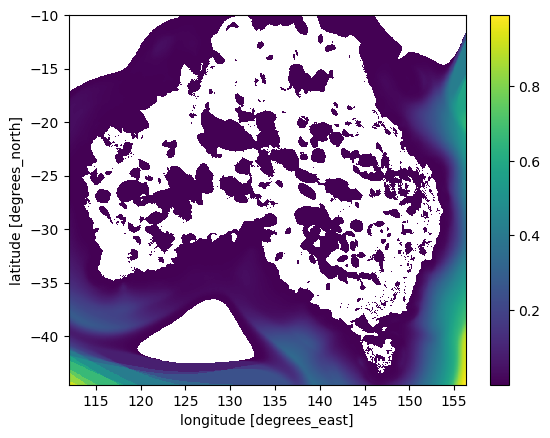

In [31]:
(tmin_above_tmax_mean.where(tmin_above_tmax_mean>0)).plot()

In [35]:
tmax

<xarray.Dataset> Size: 27GB
Dimensions:    (time: 10957, lat: 691, nv: 2, lon: 886)
Coordinates:
  * time       (time) datetime64[ns] 88kB 1985-01-01T09:00:00 ... 2014-12-31T...
  * lat        (lat) float32 3kB -44.5 -44.45 -44.4 ... -10.1 -10.05 -10.0
  * lon        (lon) float32 4kB 112.0 112.1 112.1 112.2 ... 156.1 156.2 156.2
Dimensions without coordinates: nv
Data variables:
    lat_bnds   (time, lat, nv) float32 61MB dask.array<chunksize=(365, 691, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nv) float32 78MB dask.array<chunksize=(365, 886, 2), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] 175kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    tmax       (time, lat, lon) float32 27GB dask.array<chunksize=(1, 691, 886), meta=np.ndarray>
    crs        (time) int32 44kB -2147483647 -2147483647 ... -2147483647
Attributes: (12/33)
    geospatial_lat_min:        -44.525
    geospatial_lat_max:        -9.975
    geospatial_lon_min:        111.975
    geospatial_lon_max:        156.275
    time_coverage_start:       1985-01-01T09:00:00
    date_created:              2017-02-24T17:37:02.412809
    ...                        ...
    licence:                   Data Licence: The grid data files in this AGCD...
    description:               This AGCD data is a snapshot of the operationa...
    date_issued:               2024-06-04 22:31:05
    attribution:               Data should be cited as : Australian Bureau of...
    copyright:                 (C) Copyright Commonwealth of Australia 2024, ...
    history:

## Barra check

In [2]:
import glob
baseline_tmin=glob.glob('/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/tasmin/v20240809/tasmin_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198[5-9]*.nc')+\
              glob.glob('/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/tasmin/v20240809/tasmin_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_199*.nc')+\
              glob.glob('/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/tasmin/v20240809/tasmin_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_200*.nc')+\
              glob.glob('/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/tasmin/v20240809/tasmin_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_201[0-4]*.nc')
baseline_tmin.sort()
baseline_tmin

['/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/tasmin/v20240809/tasmin_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198501-198501.nc',
 '/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/tasmin/v20240809/tasmin_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198502-198502.nc',
 '/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/tasmin/v20240809/tasmin_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198503-198503.nc',
 '/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/tasmin/v20240809/tasmin_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198504-198504.nc',
 '/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/tasmin/v20240809/tasmin_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198505-198505.nc',
 '/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/tasmin/v20240809/

In [5]:
tmin=xr.open_dataset(baseline_tmin[0]).tasmin

In [9]:
first=True
for monthfile in baseline_tmin:
    print(monthfile)
    tmin=xr.open_dataset(monthfile).tasmin
    if first:
        min_tmin=tmin.min(dim='time')
        first=False
    else:
        min_tmin=(xr.concat([min_tmin,tmin.min(dim='time')],dim='array')).min(dim='array')

/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/tasmin/v20240809/tasmin_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198501-198501.nc
/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/tasmin/v20240809/tasmin_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198502-198502.nc
/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/tasmin/v20240809/tasmin_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198503-198503.nc
/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/tasmin/v20240809/tasmin_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198504-198504.nc
/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/tasmin/v20240809/tasmin_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198505-198505.nc
/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/tasmin/v20240809/tasmin_AUS-11_ERA5_his

In [13]:
(min_tmin-273.15).min()

<xarray.DataArray 'tasmin' ()> Size: 8B
array(-39.446875)
Coordinates:
    height   float64 8B 1.5
    crs      int32 4B 0

In [20]:
filen='/g/data/ia39/australian-climate-service/release/QDC-CMIP6/BARRA-R2/ACCESS-CM2/ssp585/r4i1p1f1/day/tasmin/AUS-11/2070-2099/v20241104/tasmin_day_ACCESS-CM2_ssp585_r4i1p1f1_AUS-11_2070_qdc-additive-monthly-q100-linear_BARRA-R2-baseline-1985-2014_model-baseline-1985-2014.nc'

In [28]:
filen.split('/')[6:-4]+filen.split('/')[14:15]

['QDC-CMIP6',
 'BARRA-R2',
 'ACCESS-CM2',
 'ssp585',
 'r4i1p1f1',
 'day',
 'tasmin',
 '2070-2099']

In [29]:
filen.split('/')[6:-1]

['QDC-CMIP6',
 'BARRA-R2',
 'ACCESS-CM2',
 'ssp585',
 'r4i1p1f1',
 'day',
 'tasmin',
 'AUS-11',
 '2070-2099',
 'v20241104']

In [5]:
np.array([[0,1],[2,3]]).shape[1]

2